## Green Factor

### Green Stocks Outperformance

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

etfs = {
    "IWDA.L": "market",
    "ICLN": "clean_energy",
}

symbols = list(etfs.keys())

prices_daily = (yf.download(
    tickers=symbols, 
    progress=True
  )
  .dropna()
  )

returns_daily = (prices_daily
  .stack()
  .reset_index(level=1, drop=False)
  .reset_index()
  .rename(columns={
    "Date": "date",
    "Adj Close": "adjusted"}
  )
  # transform the Ticker column into a name column, using the etfs dictionary
  .assign(name = lambda x: x["Ticker"].map(etfs),
          ret=lambda x: x.groupby("name")["adjusted"].pct_change())
    .get(["name", "date", "ret"])
    .dropna()
)


(returns_daily
  .groupby("name")["ret"]
  .describe()
  .round(3)
)

[*********************100%%**********************]  2 of 2 completed


,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
clean_energy,3736.0,0.0,0.017,-0.128,-0.009,0.0,0.009,0.114
market,3736.0,0.0,0.010,-0.106,-0.003,0.0,0.005,0.085


In [2]:
from plotnine import *
from mizani.formatters import date_format
from mizani.breaks import date_breaks

# Compute active returns as the difference between the ETF returns and the market returns
active_returns = (
    returns_daily
    .merge(
        returns_daily.query('name == "market"')[["date", "ret"]],
        on="date",
        suffixes=("", "_market"),
    )
    .assign(active_ret=lambda x: x["ret"] - x["ret_market"])
    .drop(columns=["ret_market"])
)

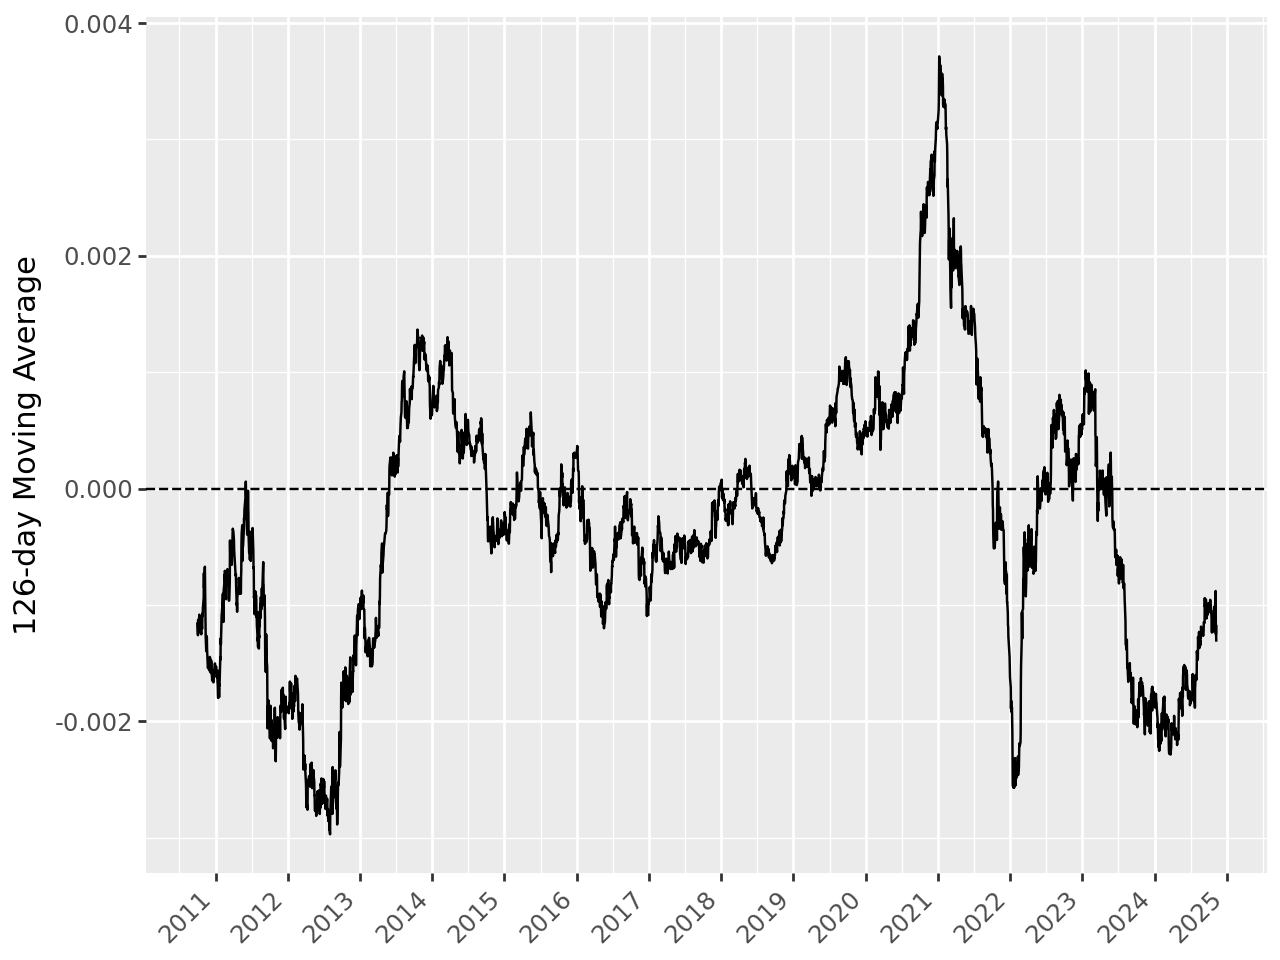

In [ ]:
# 252 day moving average

# Compute the 252-day moving average of the active returns
active_returns_ma = (
    active_returns
    .assign(
        active_ret_ma=lambda x: x.groupby("name")["active_ret"].transform(
            lambda x: x.rolling(window=252).mean()
        )
    )
    .dropna(subset=["active_ret_ma"])
    .pivot(index="date", columns="name", values="active_ret_ma")
    .get(["clean_energy"])
)

# plot the the moving average, add a horizontal line at 0
plot_ma = (
    ggplot(active_returns_ma.reset_index(), aes(x="date", y="clean_energy"))
    + geom_line()
    + geom_hline(yintercept=0, linetype="dashed")
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(
        x="",
        y="126-day Moving Average",
        title="",
        color="Name",
    )
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

plot_ma.show()


### Climate Concerns Regimes

In [ ]:
!pip install jumpmodels

#### Features Engineering

We need two inputs: (i) the returns series of our green ETF and (ii) a features dataframe.

##### Returns Series

In [18]:
ret_ser = (
    active_returns
    .pivot(index="date", columns="name", values="active_ret")
    .dropna()
    .clean_energy
)

ret_ser.head()

date
2009-09-28    0.012636
2009-09-29   -0.006282
2009-09-30    0.007348
2009-10-01   -0.026981
2009-10-02    0.003630
Name: clean_energy, dtype: float64

##### Features Dataframe

In [19]:
def compute_ewm_DD(ret_ser: pd.Series, hl: float) -> pd.Series:
    """
    Compute the exponentially weighted moving downside deviation (DD) for a return series.

    The downside deviation is calculated as the square root of the exponentially 
    weighted second moment of negative returns.

    Parameters
    ----------
    ret_ser : pd.Series
        The input return series.

    hl : float
        The halflife parameter for the exponentially weighted moving average.

    Returns
    -------
    pd.Series
        The exponentially weighted moving downside deviation for the return series.
    """
    ret_ser_neg: pd.Series = np.minimum(ret_ser, 0.)
    sq_mean = ret_ser_neg.pow(2).ewm(halflife=hl).mean()
    return np.sqrt(sq_mean)

def feature_engineer(ret_ser: pd.Series, ver: str = "v0") -> pd.DataFrame:
    """
    Engineer a set of features based on a return series.

    This function customizes the feature set according to the specified version string.

    Parameters
    ----------
    ret_ser : pd.Series
        The input return series for feature engineering.

    ver : str
        The version of feature engineering to apply. Only supports "v0".
    
    Returns
    -------
    pd.DataFrame
        The engineered feature set.
    """
    if ver == "v0":
        feat_dict = {}
        hls = [5, 20, 60]
        for hl in hls:
            # Feature 1: EWM-ret
            feat_dict[f"ret_{hl}"] = ret_ser.ewm(halflife=hl).mean()
            # Feature 2: log(EWM-DD)
            DD = compute_ewm_DD(ret_ser, hl)
            feat_dict[f"DD-log_{hl}"] = np.log(DD)
            # Feature 3: EWM-Sortino-ratio = EWM-ret/EWM-DD 
            feat_dict[f"sortino_{hl}"] = feat_dict[f"ret_{hl}"].div(DD)
        return pd.DataFrame(feat_dict)

    # try out your favorite feature sets
    else:
        raise NotImplementedError()

In [20]:
X = feature_engineer(ret_ser, ver="v0")
X.head()

c:\Users\thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log


,ret_5,DD-log_5,sortino_5,ret_20,DD-log_20,sortino_20,ret_60,DD-log_60,sortino_60
date,,,,,,,,,
2009-09-28,0.012636,-inf,inf,0.012636,-inf,inf,0.012636,-inf,inf
2009-09-29,0.002522,-5.383127,0.549136,0.003013,-5.407995,0.672485,0.003122,-5.413704,0.700861
2009-09-30,0.004358,-5.622514,1.205403,0.004508,-5.619517,1.243191,0.004547,-5.619339,1.253665
2009-10-01,-0.005173,-4.187656,-0.340717,-0.003778,-4.255480,-0.266304,-0.003472,-4.271338,-0.248657
2009-10-02,-0.002894,-4.337465,-0.221409,-0.002192,-4.375941,-0.174287,-0.002019,-4.385823,-0.162106


## Dynamic Allocation with Climate Regimes

### Black-Litterman Model

### Application with Climate Regimes and ETFs